In [ ]:
!pip install pandas matplotlib prophet streamlit pyngrok langchain tensorflow shap scikit-learn bayesian-optimization transformers


Saving demand_forecasting.csv to demand_forecasting (1).csv
Original DataFrame columns:
['date', 'product_id', 'category', 'sales_units', 'sales_revenue', 'holiday_season', 'promotion_applied', 'discount_percentage', 'competitor_price_index', 'economic_index', 'weather_impact', 'region', 'store_type', 'future_sales']
Head of the modeling DataFrame (with 'ds' and 'y'):
          ds    y
0 2022-01-01   73
1 2022-01-02  122
2 2022-01-03   57
3 2022-01-04   23
4 2022-01-05   76


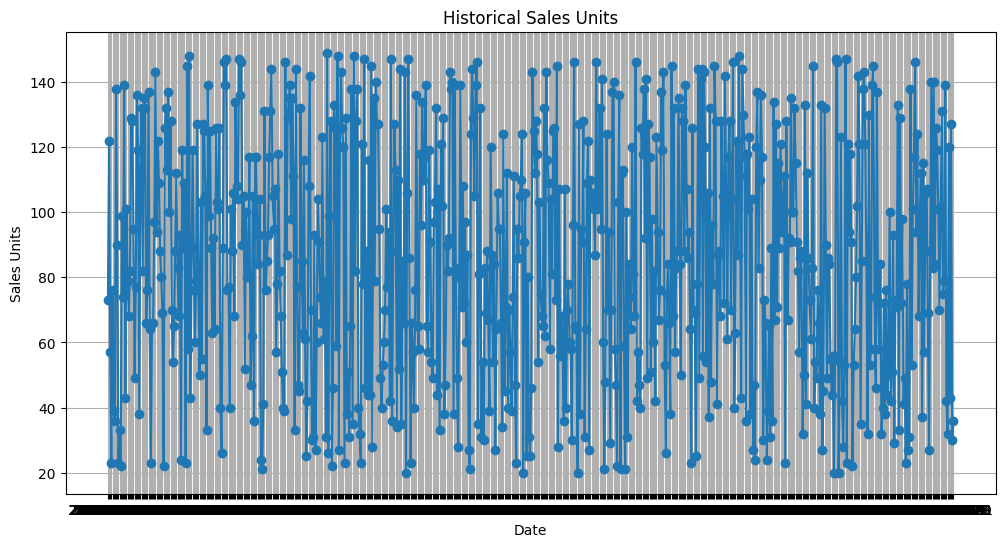

In [ ]:
from google.colab import files
uploaded = files.upload()

import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("demand_forecasting.csv")
print("Original DataFrame columns:")
print(df.columns.tolist())


df_model = df.copy()
df_model['ds'] = pd.to_datetime(df_model['date'])
df_model['y'] = df_model['sales_units']

print("Head of the modeling DataFrame (with 'ds' and 'y'):")
print(df_model[['ds', 'y']].head())

plt.figure(figsize=(12,6))
plt.plot(df['date'], df['sales_units'], marker='o')
plt.title("Historical Sales Units")
plt.xlabel("Date")
plt.ylabel("Sales Units")
plt.grid(True)
plt.show()


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3bd9hpgy/yutjor2c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3bd9hpgy/xb2o2ufi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98428', 'data', 'file=/tmp/tmp3bd9hpgy/yutjor2c.json', 'init=/tmp/tmp3bd9hpgy/xb2o2ufi.json', 'output', 'file=/tmp/tmp3bd9hpgy/prophet_modelmxtlsvf8/prophet_model-20250413184357.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 22 forecasts with cutoffs between 2022-03-11 00:00:00 and 2023-12-01 00:00:00


  0%|          | 0/22 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp3bd9hpgy/ms9dawdn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3bd9hpgy/vz6e29kd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69810', 'data', 'file=/tmp/tmp3bd9hpgy/ms9dawdn.json', 'init=/tmp/tmp3bd9hpgy/vz6e29kd.json', 'output', 'file=/tmp/tmp3bd9hpgy/prophet_modelgh8kcsgx/prophet_model-20250413184357.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:43:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3bd9hpgy/jzv1rk1t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3bd9hpgy/ce94xq7h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

Prophet cross-validation performance:
  horizon          mse       rmse        mae      mape     mdape     smape  \
0  3 days  1488.354701  38.579200  32.926762  0.604764  0.303181  0.417625   
1  4 days  1450.414003  38.084301  31.839485  0.620222  0.282082  0.407137   
2  5 days  1534.020299  39.166571  33.669044  0.678846  0.336722  0.442759   
3  6 days  1534.635871  39.174429  34.084938  0.655796  0.353061  0.442725   
4  7 days  1653.178892  40.659303  35.835110  0.628205  0.371302  0.450483   

   coverage  
0  0.954545  
1  0.954545  
2  0.984848  
3  0.969697  
4  0.984848  


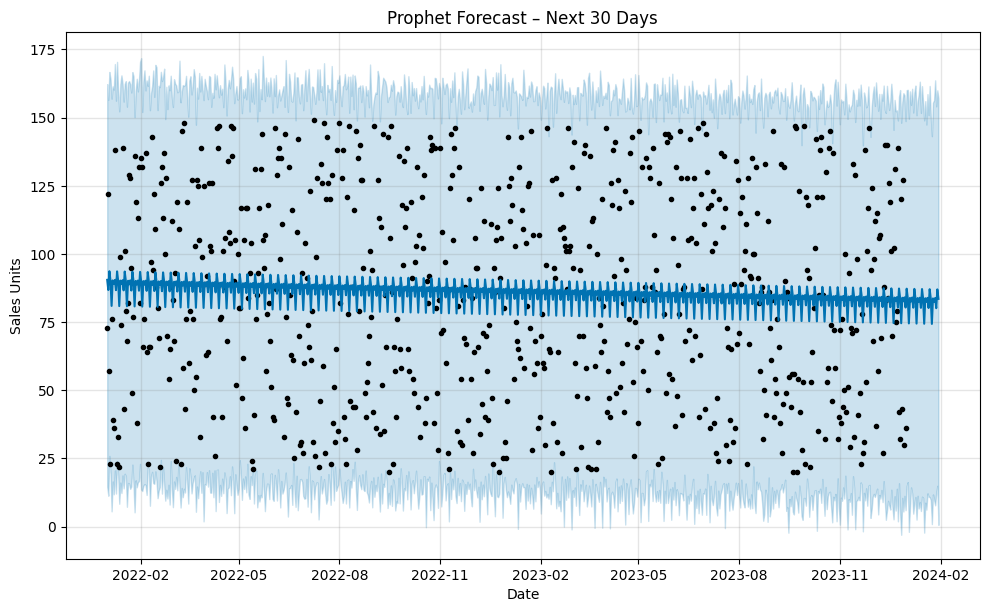

In [ ]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

model_prophet = Prophet(interval_width=0.95, daily_seasonality=True)
model_prophet.fit(df_model[['ds', 'y']])

future = model_prophet.make_future_dataframe(periods=30)
forecast_prophet = model_prophet.predict(future)

df_cv = cross_validation(model_prophet, initial='60 days', period='30 days', horizon='30 days')
df_p = performance_metrics(df_cv)
print("Prophet cross-validation performance:")
print(df_p.head())

fig = model_prophet.plot(forecast_prophet)
plt.title("Prophet Forecast – Next 30 Days")
plt.xlabel("Date")
plt.ylabel("Sales Units")
plt.show()


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_model[['y']].values)

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i:(i + seq_length)])
        ys.append(data[i + seq_length])
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 10
X, y_lstm = create_sequences(data_scaled, SEQ_LENGTH)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y_lstm[:split], y_lstm[split:]

lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2, verbose=1)

predictions = []
last_sequence = X_test[-1]

for _ in range(30):
    pred = lstm_model.predict(last_sequence.reshape(1, SEQ_LENGTH, 1))[0]
    pred = pred.reshape(1, 1)
    predictions.append(pred)
    last_sequence = np.vstack([last_sequence[1:], pred])

predictions_orig = scaler.inverse_transform(np.concatenate(predictions, axis=0))

print("Forecasted values for the next 30 days:")
print(predictions_orig)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.2469 - val_loss: 0.0968
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0922 - val_loss: 0.0890
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0891 - val_loss: 0.0909
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0890 - val_loss: 0.0886
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0917 - val_loss: 0.0876
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0884 - val_loss: 0.0860
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0881 - val_loss: 0.0860
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0916 - val_loss: 0.0862
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0875 - val_loss: 0.0844
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0876 - val_loss: 0.0850
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0852 - val_loss: 0.0839
Epoch 12/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0

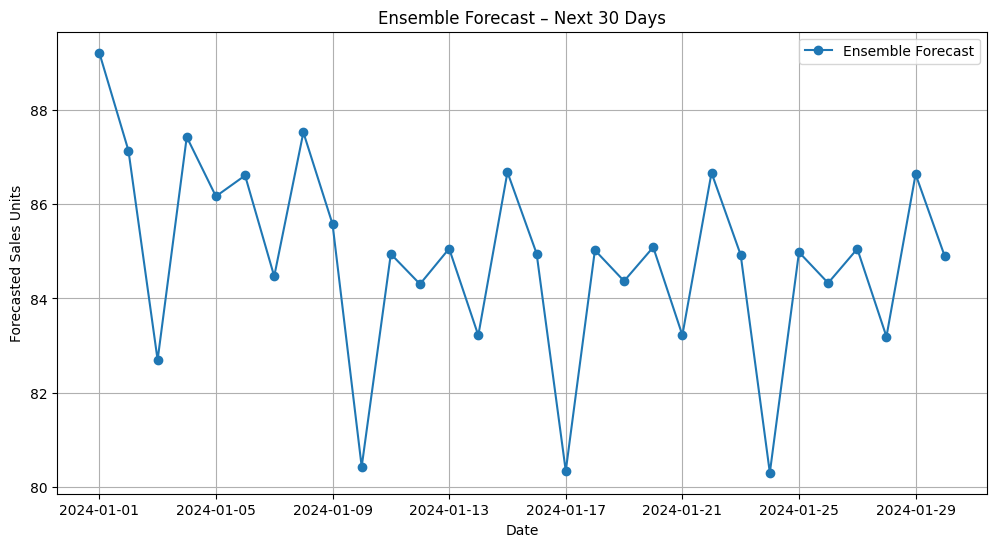

In [ ]:
future_dates = pd.date_range(start=df_model['ds'].max() + pd.Timedelta(days=1), periods=30)

ensemble_forecast = pd.DataFrame({
    'ds': future_dates,
    'forecast': (forecast_prophet.tail(30)['yhat'].values + predictions_orig.flatten()) / 2
})

plt.figure(figsize=(12,6))
plt.plot(ensemble_forecast['ds'], ensemble_forecast['forecast'], marker='o', label='Ensemble Forecast')
plt.title("Ensemble Forecast – Next 30 Days")
plt.xlabel("Date")
plt.ylabel("Forecasted Sales Units")
plt.legend()
plt.grid(True)
plt.show()


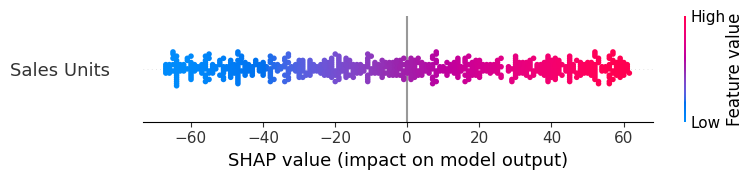

In [ ]:
import shap
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100)
X_rf = df[['sales_units']]
rf_model.fit(X_rf, df['sales_units'])

explainer = shap.Explainer(rf_model, X_rf)
shap_values = explainer(X_rf)

shap.summary_plot(shap_values, X_rf, feature_names=['Sales Units'])


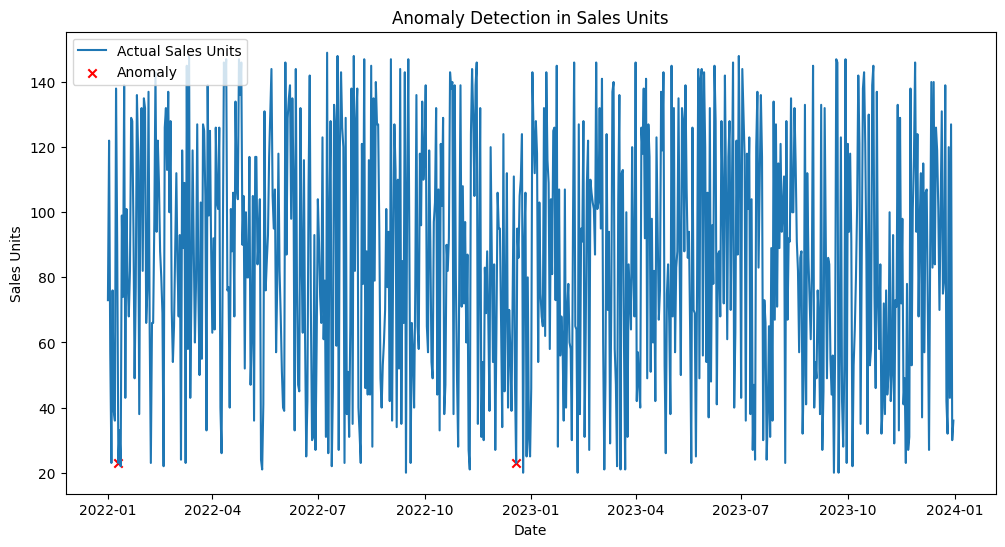

In [ ]:
df_model['yhat'] = forecast_prophet['yhat'][:len(df_model)]
df_model['anomaly'] = ((df_model['y'] < forecast_prophet['yhat_lower'][:len(df_model)]) |
                       (df_model['y'] > forecast_prophet['yhat_upper'][:len(df_model)]))
anomalies = df_model[df_model['anomaly']]

plt.figure(figsize=(12,6))
plt.plot(df_model['ds'], df_model['y'], label="Actual Sales Units")
plt.scatter(anomalies['ds'], anomalies['y'], color='red', label="Anomaly", marker='x')
plt.title("Anomaly Detection in Sales Units")
plt.xlabel("Date")
plt.ylabel("Sales Units")
plt.legend()
plt.show()


In [ ]:
def calculate_eoq(demand, ordering_cost, holding_cost):
    import numpy as np
    return np.sqrt((2 * demand * ordering_cost) / holding_cost)

average_demand = ensemble_forecast['forecast'].mean()
ordering_cost = 50
holding_cost = 2

eoq = calculate_eoq(average_demand, ordering_cost, holding_cost)
print("Optimal Order Quantity (EOQ):", eoq)


Optimal Order Quantity (EOQ): 65.13331727458032


In [ ]:
!pip install langchain[community]


In [ ]:
!pip install --upgrade langchain


In [ ]:
!pip install -U langchain-huggingface


In [ ]:
!pip install -U langchain-huggingface


In [ ]:
!pip install transformers


In [ ]:
import os
from langchain import LLMChain, PromptTemplate
from langchain.llms import HuggingFacePipeline

os.environ["HUGGINGFACEHUB_API_TOKEN"] = ""

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline


tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-xl")
model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-xl")

pipe = pipeline(
    "text2text-generation",
    model=model,
    tokenizer=tokenizer,
    max_length=512
)

llm = HuggingFacePipeline(pipeline=pipe)

template = """
You are an expert supply chain consultant. Based on the ensemble forecast data for the next 7 days:
{forecast_summary}

And considering an optimal order quantity of {eoq_value},
answer the following question:
{user_query}
"""

prompt = PromptTemplate(
    input_variables=["forecast_summary", "eoq_value", "user_query"],
    template=template
)

agent_chain = LLMChain(llm=llm, prompt=prompt)

import pandas as pd
import numpy as np

dates = pd.date_range("2024-01-01", periods=30)
forecasts = np.random.randint(50, 150, size=30)
ensemble_forecast = pd.DataFrame({"ds": dates, "forecast": forecasts})
eoq = 100

forecast_summary = ensemble_forecast[['ds', 'forecast']].tail(7).to_json(date_format="iso")
user_query = "What inventory adjustments would you recommend for next week?"

agent_response = agent_chain.invoke({
    "forecast_summary": forecast_summary,
    "eoq_value": eoq,
    "user_query": user_query
})
print("HuggingFacePipeline Agent Response:", agent_response)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cpu
<ipython-input-14-2ea64a54055e>:25: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFacePipeline``.
  llm = HuggingFacePipeline(pipeline=pipe)
<ipython-input-14-2ea64a54055e>:41: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  agent_chain = LLMChain(llm=llm, prompt=prompt)


HuggingFacePipeline Agent Response: {'forecast_summary': '{"ds":{"23":"2025-05-24T00:00:00.000","24":"2025-05-25T00:00:00.000","25":"2025-05-26T00:00:00.000","26":"2025-05-27T00:00:00.000","27":"2025-05-28T00:00:00.000","28":"2025-05-29T00:00:00.000","29":"2025-05-30T00:00:00.000"},"forecast":{"23":84,"24":75,"25":65,"26":58,"27":81,"28":86,"29":102}}', 'eoq_value': 100, 'user_query': 'What inventory adjustments would you recommend for next week?', 'text': 'a) Order 100 more than the optimal order quantity of 86. b) Order 100 less than the optimal order quantity of 84. c) Order 100 more than the optimal order quantity of 81.'}


In [ ]:
from transformers import pipeline

codegen_pipeline = pipeline("text-generation", model="Salesforce/codegen-350M-multi")

def generate_code(prompt_text, max_length=100):
    generated = codegen_pipeline(prompt_text, max_length=max_length, do_sample=True)
    return generated[0]['generated_text']

codegen_prompt = "def moving_average(data):\n    \"\"\"Compute the moving average of a list of numbers.\"\"\"\n"
generated_code = generate_code(codegen_prompt)
print("Generated CodeSnippet:\n", generated_code)


Some weights of the model checkpoint at Salesforce/codegen-350M-multi were not used when initializing CodeGenForCausalLM: ['transformer.h.0.attn.causal_mask', 'transformer.h.1.attn.causal_mask', 'transformer.h.10.attn.causal_mask', 'transformer.h.11.attn.causal_mask', 'transformer.h.12.attn.causal_mask', 'transformer.h.13.attn.causal_mask', 'transformer.h.14.attn.causal_mask', 'transformer.h.15.attn.causal_mask', 'transformer.h.16.attn.causal_mask', 'transformer.h.17.attn.causal_mask', 'transformer.h.18.attn.causal_mask', 'transformer.h.19.attn.causal_mask', 'transformer.h.2.attn.causal_mask', 'transformer.h.3.attn.causal_mask', 'transformer.h.4.attn.causal_mask', 'transformer.h.5.attn.causal_mask', 'transformer.h.6.attn.causal_mask', 'transformer.h.7.attn.causal_mask', 'transformer.h.8.attn.causal_mask', 'transformer.h.9.attn.causal_mask']
- This IS expected if you are initializing CodeGenForCausalLM from the checkpoint of a model trained on another task or with another architecture (

Generated CodeSnippet:
 def moving_average(data):
    """Compute the moving average of a list of numbers."""
    mv = moving_avg(data, axis=0, dtype='float')
    for val in mv:
        mv[val] = 0.5 * float(val if type(val) in NUMPY_TYPE else 0)
    return mv


def sum(*args):
    """Compute the sum of


In [ ]:
%%writefile app.py
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
import os
import shap
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM
from langchain import LLMChain, PromptTemplate
from langchain.llms import HuggingFacePipeline

os.environ["HUGGINGFACEHUB_API_TOKEN"] = ""

st.set_page_config(page_title="Supply Chain Optimization Dashboard", layout="wide")

st.title("Supply Chain Optimization & Demand Forecasting System")

@st.cache
def load_data():
    df = pd.read_csv("demand_forecasting.csv")
    return df

df = load_data()

st.subheader("Historical Sales Data (Original Columns)")
st.line_chart(df.set_index('date')['sales_units'])

df_model = df.copy()
df_model['ds'] = pd.to_datetime(df_model['date'])
df_model['y'] = df_model['sales_units']


@st.cache
def prophet_forecast(data):
    model = Prophet(daily_seasonality=True)
    model.fit(data[['ds', 'y']])
    future = model.make_future_dataframe(periods=30)
    forecast = model.predict(future)
    return forecast

forecast_prophet = prophet_forecast(df_model)


@st.cache
def lstm_forecast(data):
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data[['y']].values)

    def create_sequences(data, seq_length):
        xs, ys = [], []
        for i in range(len(data) - seq_length):
            xs.append(data[i:(i + seq_length)])
            ys.append(data[i + seq_length])
        return np.array(xs), np.array(ys)

    SEQ_LENGTH = 10
    X, y_seq = create_sequences(data_scaled, SEQ_LENGTH)
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y_seq[:split], y_seq[split:]

    model_lstm = tf.keras.Sequential([
        tf.keras.layers.LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
        tf.keras.layers.Dense(1)
    ])
    model_lstm.compile(optimizer='adam', loss='mse')
    model_lstm.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2, verbose=0)

    predictions = []
    last_seq = X_test[-1]
    for _ in range(30):
        pred = model_lstm.predict(last_seq.reshape(1, SEQ_LENGTH, 1))[0]
        predictions.append(pred)
        last_seq = np.append(last_seq[1:], pred, axis=0)

    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    return predictions

lstm_preds = lstm_forecast(df_model)

future_dates = pd.date_range(start=df_model['ds'].max(), periods=31, closed='right')
ensemble_forecast = pd.DataFrame({
    'ds': future_dates,
    'forecast': (forecast_prophet.tail(30)['yhat'].values + lstm_preds.flatten()) / 2
})

st.subheader("Ensemble Forecast (Next 30 Days)")
fig1, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(ensemble_forecast['ds'], ensemble_forecast['forecast'], marker='o', label='Ensemble Forecast')
ax1.set_xlabel("Date")
ax1.set_ylabel("Forecasted Sales Units")
ax1.set_title("Ensemble Forecast")
ax1.legend()
st.pyplot(fig1)


def calculate_eoq(demand, ordering_cost, holding_cost):
    return np.sqrt((2 * demand * ordering_cost) / holding_cost)

avg_demand = ensemble_forecast['forecast'].mean()
ordering_cost = 50
holding_cost = 2
eoq = calculate_eoq(avg_demand, ordering_cost, holding_cost)
st.subheader("Inventory Optimization")
st.write(f"Optimal Order Quantity (EOQ): {eoq:.2f}")



tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-xl")
model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-xl")

pipe = pipeline(
    "text2text-generation",
    model=model,
    tokenizer=tokenizer,
    max_length=512
)

llm = HuggingFacePipeline(pipeline=pipe)

template = """
You are an expert supply chain consultant. Based on the ensemble forecast data for the next 7 days:
{forecast_summary}

And considering an optimal order quantity of {eoq_value},
answer the following question:
{user_query}
"""

prompt = PromptTemplate(
    input_variables=["forecast_summary", "eoq_value", "user_query"],
    template=template
)

agent_chain = LLMChain(llm=llm, prompt=prompt)
st.subheader("Ask Your Supply Chain Assistant")
user_query = st.text_input("Enter your question about sales or inventory strategy:")

if st.button("Submit Query") and user_query:
    forecast_summary = ensemble_forecast[['ds', 'forecast']].tail(7).to_json(date_format="iso")
    response = agent_chain.invoke({
        "forecast_summary": forecast_summary,
        "eoq_value": eoq,
        "user_query": user_query
    })
    st.write("Assistant Response:")
    st.write(response)


@st.cache(allow_output_mutation=True)
def load_codegen():
    return pipeline("text-generation", model="Salesforce/codegen-350M-multi")

codegen_pipeline = load_codegen()
def generate_code(prompt_text, max_length=100):
    generated = codegen_pipeline(prompt_text, max_length=max_length, do_sample=True)
    return generated[0]['generated_text']

st.subheader("Code Generation Helper")
code_prompt = st.text_area("Enter a prompt for code generation (e.g., 'def moving_average(data):'):")
if st.button("Generate Code") and code_prompt:
    generated_code = generate_code(code_prompt)
    st.code(generated_code, language="python")

df_model['yhat'] = forecast_prophet['yhat'][:len(df_model)]
df_model['anomaly'] = ((df_model['y'] < forecast_prophet['yhat_lower'][:len(df_model)]) |
                       (df_model['y'] > forecast_prophet['yhat_upper'][:len(df_model)]))
anomalies = df_model[df_model['anomaly']]

st.subheader("Anomaly Detection in Historical Sales Units")
fig2, ax2 = plt.subplots(figsize=(12, 6))
ax2.plot(df_model['ds'], df_model['y'], label="Actual Sales Units")
ax2.scatter(anomalies['ds'], anomalies['y'], color='red', marker='x', label="Anomalies")
ax2.set_xlabel("Date")
ax2.set_ylabel("Sales Units")
ax2.set_title("Anomaly Detection")
ax2.legend()
st.pyplot(fig2)


Overwriting app.py


In [ ]:
!pip install gradio


In [ ]:
!pip install pandas matplotlib prophet streamlit pyngrok langchain tensorflow shap scikit-learn bayesian-optimization transformers


In [ ]:
from pyngrok import ngrok

ngrok.set_auth_token("")  # Replace with your actual authtoken

public_url = ngrok.connect(8501)
print('Streamlit app available at:', public_url)

Streamlit app available at: NgrokTunnel: "https://14f7-34-139-150-109.ngrok-free.app" -> "http://localhost:8501"


In [ ]:
%%writefile app.py
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
import numpy as np

st.title('Sales Forecasting')
df = pd.read_csv('demand_forecasting.csv')

st.write(df.head())

df_model = df.copy()
df_model['ds'] = pd.to_datetime(df_model['date'])
df_model['y'] = df_model['sales_units']
model = Prophet()
model.fit(df_model)

future = model.make_future_dataframe(df_model, periods=30)
forecast = model.predict(future)

st.subheader('Forecast Results')
st.write(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

fig = model.plot(forecast)
st.pyplot(fig)


Overwriting app.py


In [ ]:
!streamlit run app.py &





  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.139.150.109:8501



In [13]:
!apt-get install git


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.12).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [14]:
from google.colab import auth
auth.authenticate_user()


In [15]:
!git clone https://github.com/HrushikeshReddyyyy/Demand-Inventory-Intelligence.git


Cloning into 'Demand-Inventory-Intelligence'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), done.


In [18]:
!mv /content/demand_forecasting.csv /content/Demand-Inventory-Intelligence/
!mv /content/Demand-Inventory-Intelligence.ipynb /content/Demand-Inventory-Intelligence/


mv: cannot stat '/content/demand_forecasting.csv': No such file or directory
mv: cannot stat '/content/Demand-Inventory-Intelligence.ipynb': No such file or directory


In [19]:
!ls /content



Demand-Inventory-Intelligence  sample_data


In [20]:
!mv /content/sample_data/demand_forecasting.csv /content/Demand-Inventory-Intelligence/
!mv /content/sample_data/Demand-Inventory-Intelligence.ipynb /content/Demand-Inventory-Intelligence/


mv: cannot stat '/content/sample_data/demand_forecasting.csv': No such file or directory
mv: cannot stat '/content/sample_data/Demand-Inventory-Intelligence.ipynb': No such file or directory


In [21]:
!ls /content


Demand-Inventory-Intelligence  sample_data


In [22]:
!ls /content/sample_data


anscombe.json		      mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md
